<a href="https://colab.research.google.com/github/yuvvantalreja/CAPTCHA-Image-Recognition-using-CRNN-and-BiGRU/blob/main/CAPTCHA_Text_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [2]:
import torch
from torch import nn

torch.__version__

'2.6.0+cu124'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
!nvidia-smi

Wed Aug 13 17:55:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             16W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import requests
import os
import zipfile
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim
import torch.nn.functional as F

## Data Preprocessing

In [6]:
data_path = Path("")

# If image folder doesn't exist commence download
if data_path.is_dir():
  print(f"{data_path} directory already exists... skipping download")
else:
  print(f"Image path doesn't exist creating one...")
  data_path.mkdir(parents = True, exist_ok = True)

with open(data_path/"data.zip", "wb") as f:
  request = requests.get("https://github.com/yuvvantalreja/CAPTCHA-Image-Recognition-using-CRNN-and-BiGRU/raw/main/data.zip")
  print("Downloading data")
  f.write(request.content)


with zipfile.ZipFile(data_path/"data.zip", "r") as zip_ref:
  print("Unzipping data")
  zip_ref.extractall(data_path)

. directory already exists... skipping download
Unzipping data


In [7]:
image_fns = os.listdir(data_path/"data")
print(len(image_fns))
print(np.unique([len(image_fn.split(".")[0]) for image_fn in image_fns]))

1071
[0 5]


In [8]:
image_fns = [fn for fn in image_fns if len(fn.split(".")[0]) == 5]

In [9]:
image_ns = [image_fn.split(".")[0] for image_fn in image_fns]
image_ns = "".join(image_ns)
letters = sorted(list(set(list(image_ns))))
print(len(letters))
print(letters)

19
['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [10]:
vocabulary = ["-"] + letters
print(len(vocabulary))
print(vocabulary)
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

20
['-', '2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
{0: '-', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: 'b', 9: 'c', 10: 'd', 11: 'e', 12: 'f', 13: 'g', 14: 'm', 15: 'n', 16: 'p', 17: 'w', 18: 'x', 19: 'y'}
{'-': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, 'b': 8, 'c': 9, 'd': 10, 'e': 11, 'f': 12, 'g': 13, 'm': 14, 'n': 15, 'p': 16, 'w': 17, 'x': 18, 'y': 19}


In [11]:
import random
from PIL import Image

image_path_list = list(data_path.glob("*/*.png"))
image_path_list[0]

PosixPath('data/y2436.png')

In [12]:
# Split into train and test data
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(image_path_list, test_size = 0.2, train_size = 0.8, random_state = 42)

len(train_set), len(test_set)

(832, 208)

Image Label: pf4nb


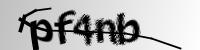

In [13]:
random.seed(42)
random_img = random.choice(image_path_list)
img = Image.open(random_img).convert('RGB')
print(f"Image Label: {str(random_img.stem)}")
img

Text(0.5, 1.0, 'Image_Label: pf4nb | Image Shape: (50, 200, 3)')

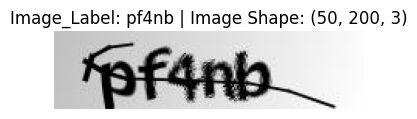

In [14]:
img_as_array = np.asarray(img)

plt.figure(figsize = (4, 3))
plt.imshow(img_as_array)
plt.axis(False)
plt.title(f"Image_Label: {str(random_img.stem)} | Image Shape: {img_as_array.shape}")

In [15]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [16]:
# Creating custom dataset

class CaptchaDataset(Dataset):
  def __init__(self, data_dir: str, image_fns: list, augment: bool = False):
    self.data_dir = data_dir
    self.image_fns = image_fns
    self.augment = augment

  def __len__(self):
    return len(self.image_fns)

  def __getitem__(self, input: int):
    image_fn = self.image_fns[input]
    image = Image.open(image_fn).convert('RGB')
    image = self.transform(image)
    text = str(image_fn.stem)
    return image, text

  def transform(self, image):
        ops = []
        if self.augment:
          ops.extend([
            transforms.RandomAffine(degrees=8, translate=(0.05, 0.1), shear=5, fill=255),
            transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
          ])
        ops.extend([
          transforms.Resize((32, 160)),
          transforms.ToTensor(),
          transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transforms.Compose(ops)(image)

In [17]:
train_dataset = CaptchaDataset("data/", train_set, augment=True)
test_dataset = CaptchaDataset("data/", test_set, augment=False)
train_dataset.__getitem__(0)

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

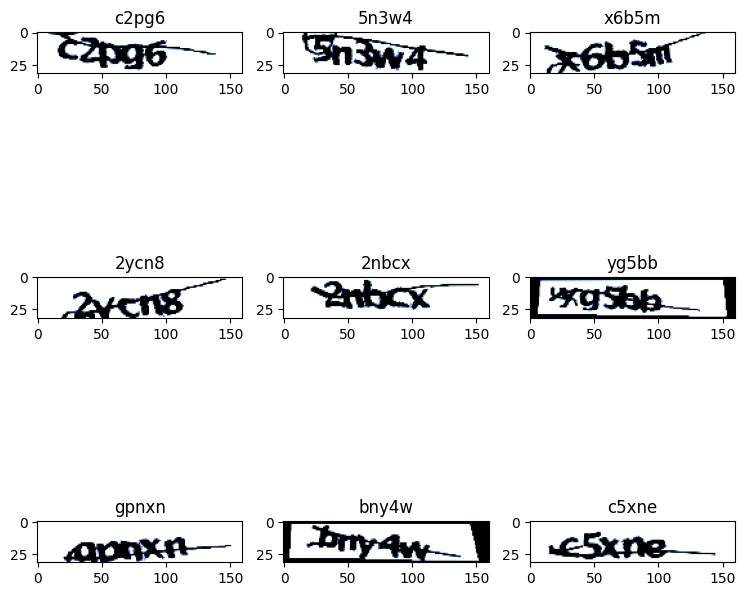

In [18]:
torch.manual_seed(0)
fig = plt.figure(figsize = (9, 9))
rows, cols = 3, 3

for i in range(1, rows*cols + 1):
  random_idx = torch.randint(0, train_dataset.__len__(), size = [1]).item()
  image, labels = train_dataset[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze().permute(1, 2, 0))
  plt.title(train_set[random_idx].stem)
  plt.axis(True)

In [19]:
os.cpu_count()

2

In [20]:
# Dataloader

BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, num_workers = os.cpu_count(), shuffle = True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, num_workers = os.cpu_count(), shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c1b158f14d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c1b12aa2e10>)

In [21]:
len(train_dataloader), len(test_dataloader)

(52, 13)

In [22]:
image_batch, text_batch = iter(train_dataloader).__next__()
print(image_batch.shape, len(text_batch))

torch.Size([16, 3, 32, 160]) 16


In [23]:
image_batch[0]

tensor([[[1.2043, 1.2043, 1.2214,  ..., 2.2489, 2.2489, 2.2489],
         [1.2043, 1.2043, 1.2214,  ..., 2.2489, 2.2489, 2.2489],
         [1.2043, 1.2043, 1.2214,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

        [[1.3606, 1.3606, 1.3782,  ..., 2.4286, 2.4286, 2.4286],
         [1.3606, 1.3606, 1.3782,  ..., 2.4286, 2.4286, 2.4286],
         [1.3606, 1.3606, 1.3782,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

        [[1.5768, 1.5768, 1.5942,  ..., 2.6400, 2.6400, 2.6400],
         [1.5768, 1.5768, 1.5942,  ..., 2.6400, 2.6400, 2.6400],
         [1.5768, 1.5768, 1.5942,  ..., 2.6400, 2.6400, 2.

## Model Creation

In [24]:
num_chars = len(char2idx)
rnn_hidden_units = 256

In [25]:
from torchvision.models import resnet18
resnet = resnet18(pretrained = True)
resnet.maxpool = nn.Identity()
list(resnet.children())[:-3]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 Identity(),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, 

* ResNet documentation: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html
* GRU Documentation: https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
* GRU vs BiGRU: https://pub.aimind.so/what-is-the-difference-between-a-gru-and-a-bigru-fbde0fbe2950
* BiGRU Explained (Papers with Code): https://paperswithcode.com/method/bigru
* Paper on combining ResNet and BiGRU Techniques for OCR:  https://www.internationaljournalssrg.org/IJECE/2024/Volume11-Issue1/IJECE-V11I1P101.pdf

In [26]:
class CRNN(nn.Module):
  def __init__(self, num_chars, rnn_hidden_units = 256, dropout = 0.1): # dropout --> used to reduce overfitting and memorization of trends in the data
    super().__init__()
    self.num_chars = num_chars
    self.rnn_hidden_units = rnn_hidden_units
    self.dropout = dropout

    resnet_modules = list(resnet.children())[:-3] # Using all except last 3 blocks of ResNet
    self.CNN1 = nn.Sequential(*resnet_modules)

    self.CNN2 = nn.Sequential(
        nn.Conv2d(256, 256, kernel_size = (3, 6), stride = 1, padding = 1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace = True)
    )
    self.linear1 = nn.LazyLinear(256)

    # RNN (BiGRU)

    self.rnn1 = nn.GRU(input_size = rnn_hidden_units,
                       hidden_size = rnn_hidden_units,
                       bidirectional = True,
                       batch_first = True
                       )
    self.rnn2 = nn.GRU(input_size = rnn_hidden_units,
                       hidden_size = rnn_hidden_units,
                       bidirectional = True,
                       batch_first = True
                       )
    self.linear2 = nn.Linear(self.rnn_hidden_units * 2, num_chars) # Why hidden_units * 2 ???

  def forward(self, batch):
        batch = self.CNN1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])

        batch = self.CNN2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])

        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])

        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])

        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])

        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])

        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])

        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])

        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])

        return batch

In [27]:
# Initializing of weights using Xavier Uniform prevents vanishing or exploding gradients during training
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [28]:
crnn = CRNN(num_chars, rnn_hidden_units=rnn_hidden_units)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [29]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('pm47f', 'nbcgb', '6m5eg', 'dfnx4', '43gey', 'f364x', 'gnc3n', '8d4wm', '25egp', 'nf7bn', 'x347n', '6ecbn', 'x7746', 'een23', 'wd2gb', 'pdyc8')
torch.Size([17, 16, 20])


In [30]:
# Loss Definitions
loss_fn = nn.CTCLoss(blank = 0)

In [31]:
def encode_text_batch(text_batch):

    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens).to(device)

    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets).to(device)

    return text_batch_targets, text_batch_targets_lens

In [32]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    # Replace potential NaN or infinite values with 0 before applying log_softmax
    text_batch_logps = F.log_softmax(torch.nan_to_num(text_batch_logits), 2) # [T, batch_size, num_classes]
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),),
                                       fill_value=text_batch_logps.size(0),
                                       dtype=torch.int32).to(device) # [batch_size]
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens)
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = loss_fn(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [33]:
compute_loss(text_batch, text_batch_logits)

tensor(7.4620, device='cuda:0', grad_fn=<MeanBackward0>)

## Training

In [34]:
epochs = 80
lr = 0.001
decay = 0.0001
clip_norm = 5

In [35]:
optimizer = torch.optim.Adam(params = crnn.parameters(), lr = lr, weight_decay = decay)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5) # makes lr dynamic to prevent vanishing/exploding gradients
optimizer

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)

In [36]:
from timeit import default_timer as timer
def print_total_time(start, end):
    total_time = total_time = end-start
    print(f"Train time on {device}: {total_time: .3f} seconds")
    return total_time

In [37]:
# Training loop

# Structure: optimizer.zero_grad() --> training logits --> computing loss --> backpropagation --> gradient descent

epoch_losses = []
iteration_losses = []
num_updates_epochs = []

start_time = timer()
for epoch in range(1, epochs + 1):

  epoch_loss_list = []
  num_updates_epoch = 0

  for image_batch, text_batch in train_dataloader:
    optimizer.zero_grad()
    text_batch_logits = crnn(image_batch.to(device))
    loss = compute_loss(text_batch, text_batch_logits)
    iteration_loss = loss.item()

    num_updates_epoch += 1
    iteration_losses.append(iteration_loss)
    epoch_loss_list.append(iteration_loss)
    loss.backward()

    # Gradient clipping used to prevent exploding gradients during training nn.
    # This becomes when the gradients become too large leading to instability and divergence during training.

    nn.utils.clip_grad_norm(crnn.parameters(), clip_norm)
    optimizer.step()

  epoch_loss = np.mean(epoch_loss_list)
  epoch_losses.append(epoch_loss)
  num_updates_epochs.append(num_updates_epoch)
  lr_scheduler.step(epoch_loss)
  if epoch % 5 == 0:
    print(f"Epoch: {epoch} | Validation Loss: {epoch_loss} | Updates: {num_updates_epoch}")
end_time = timer()
print(print_total_time(start_time, end_time))

/tmp/ipython-input-2720027829.py:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  nn.utils.clip_grad_norm(crnn.parameters(), clip_norm)


Epoch: 5 | Validation Loss: 2.9527624524556675 | Updates: 52
Epoch: 10 | Validation Loss: 2.2010738597466397 | Updates: 52
Epoch: 15 | Validation Loss: 0.473567566046348 | Updates: 52
Epoch: 20 | Validation Loss: 0.24561020001195943 | Updates: 52
Epoch: 25 | Validation Loss: 0.10597893602859515 | Updates: 52
Epoch: 30 | Validation Loss: 0.0859628718597098 | Updates: 52
Epoch: 35 | Validation Loss: 0.08293372657723151 | Updates: 52
Epoch: 40 | Validation Loss: 0.07120283277562031 | Updates: 52
Epoch: 45 | Validation Loss: 0.08675470127939032 | Updates: 52
Epoch: 50 | Validation Loss: 0.025395217136694834 | Updates: 52
Epoch: 55 | Validation Loss: 0.016701049755703516 | Updates: 52
Epoch: 60 | Validation Loss: 0.010016469405784916 | Updates: 52
Epoch: 65 | Validation Loss: 0.005971181855644458 | Updates: 52
Epoch: 70 | Validation Loss: 0.00928364548823223 | Updates: 52
Epoch: 75 | Validation Loss: 0.013707087764767213 | Updates: 52
Epoch: 80 | Validation Loss: 0.007332408305956051 | Upda

Text(0, 0.5, 'Loss')

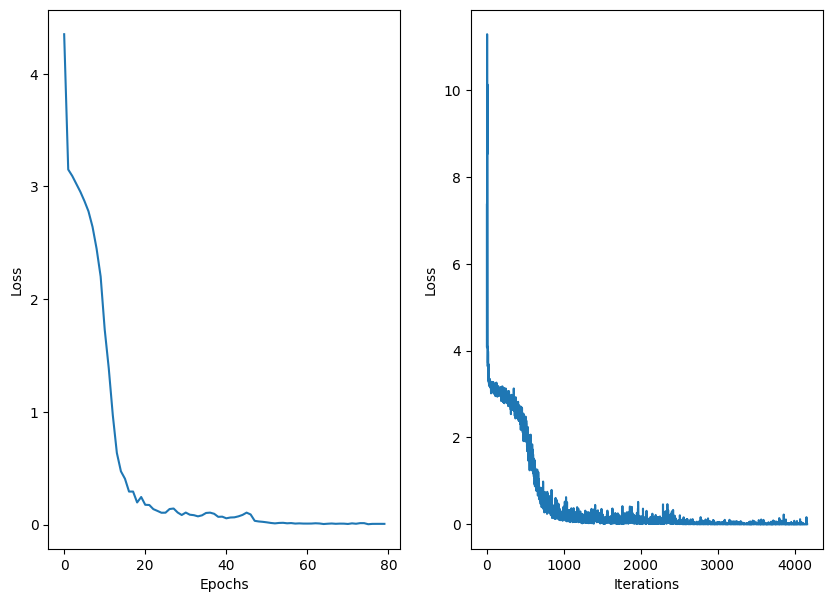

In [44]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 7))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

In [ ]:
# # Saving the model
# MODEL_PATH = Path("MODELS")

# MODEL_PATH.mkdir(parents = True, exist_ok = True)

# MODEL_NAME = 'weights01.pt'
# MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME
# # torch.save(model, Path)
# print(MODEL_SAVE_PATH)
# torch.save(crnn.state_dict(), MODEL_SAVE_PATH)

## Making Predictions

In [ ]:
# Import trained weights from github

In [ ]:
# model = CRNN(num_chars, rnn_hidden_units=rnn_hidden_units)
# model.load_state_dict(torch.load(f = "/content/weights01.pt", map_location=torch.device(device)))

In [45]:
def decode_predictions(text_batch_logits):
    tokens = text_batch_logits.argmax(2).cpu().numpy().T  # [batch_size, T]
    decoded = []
    for seq in tokens:
        prev = None
        chars = []
        for idx in seq:
            if idx != 0 and idx != prev:
                chars.append(idx2char[idx])
            prev = idx
        decoded.append("".join(chars))
    return decoded

In [46]:
train_loader = DataLoader(train_dataset, batch_size=16, num_workers=1, shuffle=False)
crnn.eval()
total_label_list = []
total_prediction_list = []
with torch.inference_mode():
  for image_batch, text_batch in tqdm(test_dataloader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        total_prediction_list.append(text_batch_pred)
        total_label_list.append(text_batch)

  0%|          | 0/13 [00:00<?, ?it/s]

In [47]:
len(total_label_list), len(total_prediction_list)

(13, 13)

In [48]:
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=1, shuffle=False)
crnn.eval()
total_test_label_list = []
total_test_pred_list = []
with torch.inference_mode():
  for image_batch, text_batch in tqdm(test_dataloader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        total_test_pred_list.append(text_batch_pred)
        total_test_label_list.append(text_batch)

  0%|          | 0/13 [00:00<?, ?it/s]

In [49]:
len(total_test_label_list), len(total_test_pred_list)

(13, 13)

In [50]:
import pandas as pd
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(train_dataset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

  0%|          | 0/52 [00:00<?, ?it/s]

In [51]:
print(results_train.shape)
results_train

(832, 2)


,actual,prediction
0,yf347,yf347
1,5n245,5n245
2,nfndw,nfndw
3,5n3w4,5n3w4
4,43gey,43gey
...,...,...
827,3wnd3,3wnd3
828,pyf65,pyf65
829,pg2yx,pg2yx
830,n6nn2,n6nn2


In [65]:
text_batch_pred[1]

'cgcgb'

In [66]:
total_prediction_list[0][0]

'mx8bb'

In [73]:
import itertools

# Flatten the list of lists for easier comparison
total_test_label_list_flat = list(itertools.chain(*total_test_label_list))
total_test_pred_list_flat = list(itertools.chain(*total_test_pred_list))

# Calculate accuracy
correct_predictions = sum(1 for actual, predicted in zip(total_test_label_list_flat, total_test_pred_list_flat) if actual == predicted)
total_predictions = len(total_test_label_list_flat)
accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

print(f"Test Set Accuracy: {accuracy:.4f}")

Test Set Accuracy: 0.9952


In [103]:
misclassified_images = []

for actual, predicted in zip(total_test_label_list_flat, total_test_pred_list_flat):
    if actual != predicted:
        misclassified_images.append({'actual': actual, 'predicted': predicted})

print(f"Number of misclassified images: {len(misclassified_images)}")
if misclassified_images:
    print("First 5 misclassified images:")
    display(misclassified_images[:5])

Number of misclassified images: 1
First 5 misclassified images:


[{'actual': 'wgnwp', 'predicted': 'wgmwp'}]

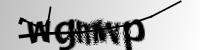

In [102]:
import matplotlib.pyplot as plt
from PIL import Image

for misclassified in misclassified_images:
  image_path = None
  for image in test_set:
    # print(image.stem)
    if misclassified['actual'] == image.stem:
      image_path = image;

plot = Image.open(image_path)
plot

**Reasoning**:
Use the actual labels and predictions from the test set to compute precision, recall, and F1-score for each character using the `classification_report` function.



In [101]:
from sklearn.metrics import classification_report
import itertools

total_test_label_list_chars = list(itertools.chain(*total_test_label_list_flat))
total_test_pred_list_chars = list(itertools.chain(*total_test_pred_list_flat))

report = classification_report(total_test_label_list_chars, total_test_pred_list_chars, labels=vocabulary, zero_division=0)

print(report)

              precision    recall  f1-score   support

           -       0.00      0.00      0.00         0
           2       1.00      1.00      1.00        47
           3       1.00      1.00      1.00        53
           4       1.00      1.00      1.00        41
           5       1.00      1.00      1.00        58
           6       1.00      1.00      1.00        42
           7       1.00      1.00      1.00        52
           8       1.00      1.00      1.00        54
           b       1.00      1.00      1.00        57
           c       1.00      1.00      1.00        49
           d       1.00      1.00      1.00        50
           e       1.00      1.00      1.00        38
           f       1.00      1.00      1.00        59
           g       1.00      1.00      1.00        50
           m       0.98      1.00      0.99        62
           n       1.00      0.99      1.00       111
           p       1.00      1.00      1.00        54
           w       1.00    